# TabNet Regressor Tutorial 

- source: https://www.kaggle.com/code/carlmcbrideellis/tabnet-a-very-simple-regression-example

## Basic Packages

In [1]:
import pandas as pd
import numpy  as np
from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [3]:
!jupyter lab --version

4.1.3


In [4]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [5]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 3090 (UUID: GPU-24449304-a305-dbe0-a5c8-bc765274bece)
GPU 1: NVIDIA GeForce RTX 3090 (UUID: GPU-1761614d-0d31-5a98-6d73-e9cabf8b877a)


## Read, Explore and Load Data

#### Read Data

In [6]:
!pwd

/app/tabnet/tutorial/tabnet-regressor


In [7]:
!ls /app/tabnet/tutorial/tabnet-regressor/data

data_description.txt  sample_submission.csv  solution.csv  test.csv  train.csv


In [8]:
datadir = '/app/tabnet/tutorial/tabnet-regressor/data/'

In [9]:
%%time
traindf = pd.read_csv(datadir+'train.csv')
testdf  = pd.read_csv(datadir+'test.csv')

CPU times: user 36.8 ms, sys: 109 µs, total: 36.9 ms
Wall time: 36.4 ms


In [10]:
soldf = pd.read_csv(datadir+'solution.csv')

In [11]:
traindf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [12]:
testdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

In [13]:
soldf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Id         1459 non-null   int64  
 1   SalePrice  1459 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 22.9 KB


In [14]:
testdf[['Id','SaleType','SaleCondition']].head()

,Id,SaleType,SaleCondition
0,1461,WD,Normal
1,1462,WD,Normal
2,1463,WD,Normal
3,1464,WD,Normal
4,1465,WD,Normal


In [15]:
soldf.head()

,Id,SalePrice
0,1461,105000.0
1,1462,172000.0
2,1463,189900.0
3,1464,195500.0
4,1465,191500.0


In [16]:
traindf[['Id','SaleType','SaleCondition','SalePrice']].head()

,Id,SaleType,SaleCondition,SalePrice
0,1,WD,Normal,208500
1,2,WD,Normal,181500
2,3,WD,Normal,223500
3,4,WD,Abnorml,140000
4,5,WD,Normal,250000


#### Input Features

In [17]:
features = ['LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 
            'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'TotalBsmtSF', 
            '1stFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 
            'BsmtHalfBath', 'HalfBath', 'BedroomAbvGr',  'Fireplaces', 
            'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 
            'EnclosedPorch',  'PoolArea', 'YrSold']

#### Data Prep.

In [18]:
X      = traindf[features].astype('float64')
y      = np.log1p(traindf["SalePrice"].astype('float64'))
X_test = testdf[features].astype('float64')
y_true = soldf["SalePrice"].astype('float64')

In [19]:
# Impute Data using mean (or median)
X      =      X.apply(lambda x: x.fillna(x.mean()),axis=0)
X_test = X_test.apply(lambda x: x.fillna(x.mean()),axis=0)

In [20]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   LotArea        1460 non-null   float64
 1   OverallQual    1460 non-null   float64
 2   OverallCond    1460 non-null   float64
 3   YearBuilt      1460 non-null   float64
 4   YearRemodAdd   1460 non-null   float64
 5   BsmtFinSF1     1460 non-null   float64
 6   BsmtFinSF2     1460 non-null   float64
 7   TotalBsmtSF    1460 non-null   float64
 8   1stFlrSF       1460 non-null   float64
 9   LowQualFinSF   1460 non-null   float64
 10  GrLivArea      1460 non-null   float64
 11  BsmtFullBath   1460 non-null   float64
 12  BsmtHalfBath   1460 non-null   float64
 13  HalfBath       1460 non-null   float64
 14  BedroomAbvGr   1460 non-null   float64
 15  Fireplaces     1460 non-null   float64
 16  GarageCars     1460 non-null   float64
 17  GarageArea     1460 non-null   float64
 18  WoodDeck

In [21]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   LotArea        1459 non-null   float64
 1   OverallQual    1459 non-null   float64
 2   OverallCond    1459 non-null   float64
 3   YearBuilt      1459 non-null   float64
 4   YearRemodAdd   1459 non-null   float64
 5   BsmtFinSF1     1459 non-null   float64
 6   BsmtFinSF2     1459 non-null   float64
 7   TotalBsmtSF    1459 non-null   float64
 8   1stFlrSF       1459 non-null   float64
 9   LowQualFinSF   1459 non-null   float64
 10  GrLivArea      1459 non-null   float64
 11  BsmtFullBath   1459 non-null   float64
 12  BsmtHalfBath   1459 non-null   float64
 13  HalfBath       1459 non-null   float64
 14  BedroomAbvGr   1459 non-null   float64
 15  Fireplaces     1459 non-null   float64
 16  GarageCars     1459 non-null   float64
 17  GarageArea     1459 non-null   float64
 18  WoodDeck

In [22]:
X.head().T

,0,1,2,3,4
LotArea,8450.0,9600.0,11250.0,9550.0,14260.0
OverallQual,7.0,6.0,7.0,7.0,8.0
OverallCond,5.0,8.0,5.0,5.0,5.0
YearBuilt,2003.0,1976.0,2001.0,1915.0,2000.0
YearRemodAdd,2003.0,1976.0,2002.0,1970.0,2000.0
BsmtFinSF1,706.0,978.0,486.0,216.0,655.0
BsmtFinSF2,0.0,0.0,0.0,0.0,0.0
TotalBsmtSF,856.0,1262.0,920.0,756.0,1145.0
1stFlrSF,856.0,1262.0,920.0,961.0,1145.0
LowQualFinSF,0.0,0.0,0.0,0.0,0.0


In [23]:
X_test.head().T

,0,1,2,3,4
LotArea,11622.0,14267.0,13830.0,9978.0,5005.0
OverallQual,5.0,6.0,5.0,6.0,8.0
OverallCond,6.0,6.0,5.0,6.0,5.0
YearBuilt,1961.0,1958.0,1997.0,1998.0,1992.0
YearRemodAdd,1961.0,1958.0,1998.0,1998.0,1992.0
BsmtFinSF1,468.0,923.0,791.0,602.0,263.0
BsmtFinSF2,144.0,0.0,0.0,0.0,0.0
TotalBsmtSF,882.0,1329.0,928.0,926.0,1280.0
1stFlrSF,896.0,1329.0,928.0,926.0,1280.0
LowQualFinSF,0.0,0.0,0.0,0.0,0.0


In [24]:
X      = X.to_numpy()
y      = y.to_numpy().reshape(-1, 1)
X_test = X_test.to_numpy()

## Training ... 

In [25]:
%%time 
kf = KFold(n_splits=5, random_state=42, shuffle=True)
predictions_array =[]
CV_score_array    =[]
feature_importance_array = []

#for train_index, test_index in kf.split(X):
for train_index, test_index in tqdm(kf.split(X), total=kf.get_n_splits(), desc="KFold Splits", \
                                    position=0, leave=True):
    X_train, X_valid = X[train_index], X[test_index]
    y_train, y_valid = y[train_index], y[test_index]
    regressor = TabNetRegressor(verbose=0,seed=42)
    regressor.fit(X_train=X_train, y_train=y_train,
              eval_set=[(X_valid, y_valid)],
              patience=300, max_epochs=2000,
              eval_metric=['rmse'])
    CV_score_array.append(regressor.best_cost)
    predictions_array.append(np.expm1(regressor.predict(X_test)))
    feature_importance_array.append(regressor.feature_importances_)

predictions = np.mean(predictions_array,axis=0)
average_feature_importance = np.mean(np.array(feature_importance_array), axis=0)

KFold Splits:   0%|                                                                                                                                                 | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
KFold Splits:  20%|███████████████████████████▍                                                                                                             | 1/5 [01:00<04:02, 60.57s/it]


Early stopping occurred at epoch 1907 with best_epoch = 1607 and best_val_0_rmse = 0.15308


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
KFold Splits:  40%|██████████████████████████████████████████████████████▊                                                                                  | 2/5 [01:47<02:37, 52.55s/it]


Early stopping occurred at epoch 1448 with best_epoch = 1148 and best_val_0_rmse = 0.14154


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
KFold Splits:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                      | 3/5 [02:03<01:11, 35.71s/it]


Early stopping occurred at epoch 489 with best_epoch = 189 and best_val_0_rmse = 0.28949


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
KFold Splits:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 4/5 [02:39<00:35, 35.94s/it]


Early stopping occurred at epoch 1127 with best_epoch = 827 and best_val_0_rmse = 0.165


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
KFold Splits: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:14<00:00, 38.81s/it]


Early stopping occurred at epoch 1056 with best_epoch = 756 and best_val_0_rmse = 0.16247
CPU times: user 3min 13s, sys: 281 ms, total: 3min 14s
Wall time: 3min 14s


## Results 

#### Performance Metrics

In [26]:
CV_score_array 

[0.1530821205955875,
 0.14153580497856086,
 0.28949295831262056,
 0.164999288856484,
 0.1624699820207458]

In [27]:
print("The CV score is %.5f" % np.mean(CV_score_array,axis=0) )

The CV score is 0.18232


In [28]:
len(y_true), len(predictions)

(1459, 1459)

In [29]:
from sklearn.metrics import mean_squared_log_error
RMSLE = np.sqrt( mean_squared_log_error(y_true, predictions) )
print("The LB score is %.5f" % RMSLE )

The LB score is 0.16828


#### Average Feature Importance

In [30]:
# Create a DataFrame to store feature names and their importance scores
importance_df = pd.DataFrame({'Feature': features, 'Importance': average_feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=True)

# Print or visualize the feature importance
print(importance_df)

          Feature  Importance
12   BsmtHalfBath    0.000097
9    LowQualFinSF    0.001091
2     OverallCond    0.004369
6      BsmtFinSF2    0.005307
5      BsmtFinSF1    0.009721
0         LotArea    0.017406
21       PoolArea    0.020378
8        1stFlrSF    0.020796
19    OpenPorchSF    0.020905
7     TotalBsmtSF    0.021574
3       YearBuilt    0.025161
14   BedroomAbvGr    0.027528
17     GarageArea    0.028062
15     Fireplaces    0.034271
18     WoodDeckSF    0.035424
10      GrLivArea    0.039389
22         YrSold    0.041564
20  EnclosedPorch    0.050803
1     OverallQual    0.055525
4    YearRemodAdd    0.087548
13       HalfBath    0.134410
16     GarageCars    0.151938
11   BsmtFullBath    0.166734


## Visualize the predictions 

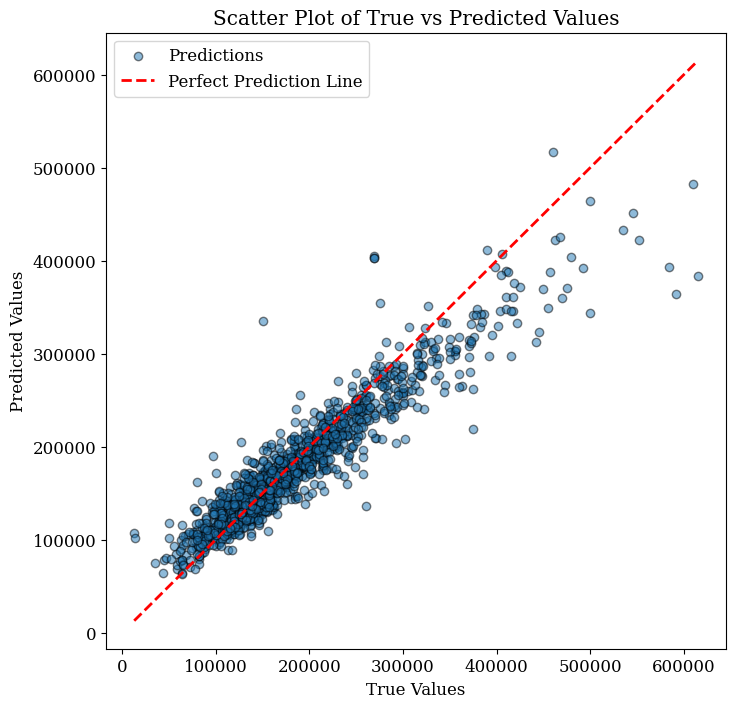

In [31]:
#plot settings
plt.rc('font', family='serif') 
#plt.rc('font', serif='Times New Roman') 
plt.rcParams.update({'font.size': 12})
plt.rcParams['mathtext.fontset'] = 'stix'

# Create scatter plot
plt.figure(figsize=(8, 8))
plt.scatter(y_true, predictions, alpha=0.5, edgecolors='k', label='Predictions')
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--', \
         lw=2, label='Perfect Prediction Line')

# Add titles and labels
plt.title('Scatter Plot of True vs Predicted Values')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.legend()

# Show plot
plt.show()


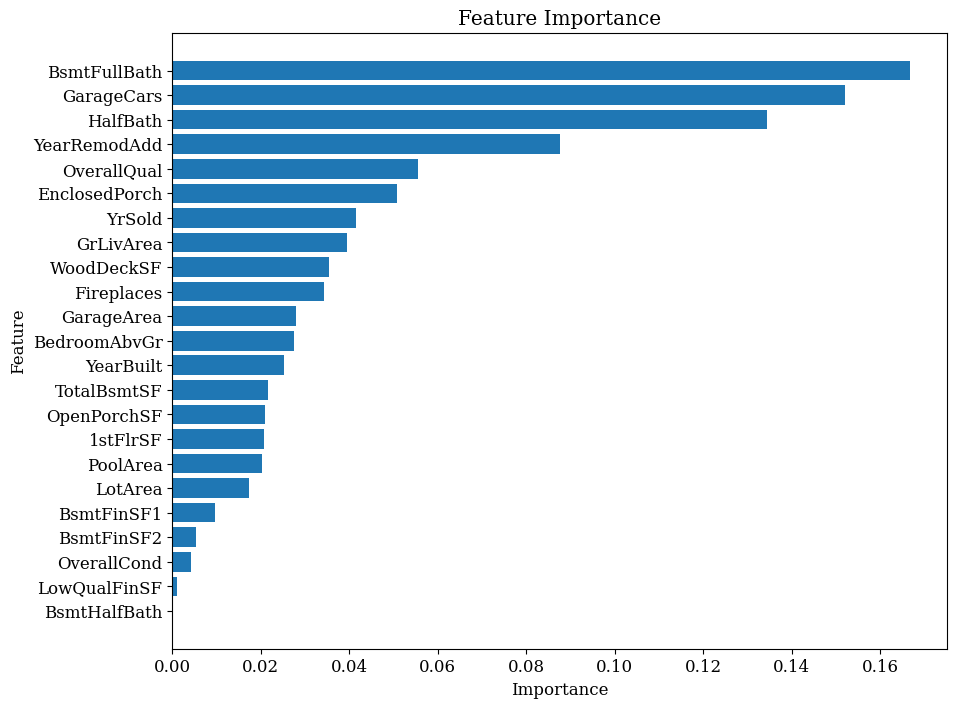

In [32]:
# Visualize the feature importance (example with matplotlib)
#plot settings
plt.rc('font', family='serif') 
#plt.rc('font', serif='Times New Roman') 
plt.rcParams.update({'font.size': 12})
plt.rcParams['mathtext.fontset'] = 'stix'

plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()